In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [64]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [65]:
path = "/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/2_Data_Processing/normalizing_data/normalized_data.csv"
data = pd.read_csv(path)

In [66]:
X = data.drop(columns=['price'])  # Variables predictoras
y = data['price']  # Variable objetivo

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
def build_model(optimizer_name='Adam'):
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=0.001)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=0.001, momentum=0.9)
    else:
        raise ValueError(f"Optimizador {optimizer_name} no reconocido")

    model = Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),  # Definir explícitamente la capa de entrada
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Capa de salida
    ])
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Optimizadores como nombres en lugar de instancias
optimizers = ['Adam', 'SGD']

# Diccionario para almacenar resultados
results = {}

early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

for opt_name in optimizers:
    fold_mae = []

    for train_idx, val_idx in kfold.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Crear un nuevo modelo con el optimizador especificado
        model = build_model(optimizer_name=opt_name)
        
        # Entrenar el modelo (reduce épocas a 20 para pruebas iniciales)
        history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32,
                            validation_data=(X_val_fold, y_val_fold), verbose=0,
                            callbacks=[early_stopping])

        # Evaluar el modelo
        val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
        fold_mae.append(val_mae)

    # Guardar el MAE promedio en los resultados
    results[opt_name] = np.mean(fold_mae)

# Imprimir los resultados de validación cruzada
print("Resultados de Validación Cruzada (MAE promedio):")
for opt, mae in results.items():
    print(f"{opt}: {mae:.4f}")



/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/environment/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/environment/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/environment/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning

Resultados de Validación Cruzada (MAE promedio):
Adam: 0.4293
SGD: 0.3161


/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/environment/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [71]:
best_optimizer_name = 'Adam' if results['Adam'] < results['SGD'] else 'SGD'

model = build_model(optimizer_name=best_optimizer_name)

history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
                    validation_split=0.2, verbose=1, callbacks=[
                        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
                    ])

Epoch 1/100
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 21.6787 - mae: 4.3690

/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/environment/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 15.7957 - mae: 3.5156 - val_loss: 3.5274 - val_mae: 1.4751 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.2920 - mae: 1.1696 - val_loss: 1.0893 - val_mae: 0.7651 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9145 - mae: 0.7171 - val_loss: 0.9003 - val_mae: 0.7242 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5728 - mae: 0.5823 - val_loss: 0.6610 - val_mae: 0.5962 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4858 - mae: 0.5320 - val_loss: 0.5830 - val_mae: 0.5491 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4197 - mae: 0.4855 - val_loss: 0.5181 - val_mae: 0.5167 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3166 - mae: 0.4279 - val_loss: 0.4893 - val_mae: 0.5084 - learning_rate: 0.0010
Epoch 8/100
21/21

In [72]:
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calcular métricas
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Calcular el RMSE como porcentaje de la media de los datos de prueba
mean_value = np.mean(y_test)
rmse_percentage = (rmse_test / mean_value) * 100

# Imprimir métricas
print("\nMétricas de Entrenamiento:")
print(f'MAE: {mae_train:.4f}')
print(f'RMSE: {rmse_train:.4f}')
print(f'R²: {r2_train:.4f}')

print("\nMétricas de Prueba:")
print(f'MAE: {mae_test:.4f}')
print(f'RMSE: {rmse_test:.4f}')
print(f'R²: {r2_test:.4f}')

if rmse_percentage > 15:
    print(f'El RMSE es superior al 15% de la media: {rmse_percentage:.2f}%')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Métricas de Entrenamiento:
MAE: 0.1033
RMSE: 0.1446
R²: 0.9930

Métricas de Prueba:
MAE: 0.1744
RMSE: 0.2679
R²: 0.9778


In [73]:
# Realizar las predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Revertir la normalización
y_pred_original = y_pred * 1000000  # Multiplicar las predicciones por el factor de normalización
y_true_original = y_test.values * 1000000  # Multiplicar los valores reales por el factor de normalización


# Calcular las métricas en el dominio original
mae_original = mean_absolute_error(y_true_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
r2_original = r2_score(y_true_original, y_pred_original)

# Mostrar las métricas
print("Métricas en el dominio original:")
print(f"MAE: {mae_original:.4f}")
print(f"RMSE: {rmse_original:.4f}")
print(f"R²: {r2_original:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Métricas en el dominio original:
MAE: 174360.4372
RMSE: 267856.3293
R²: 0.9778


/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/environment/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


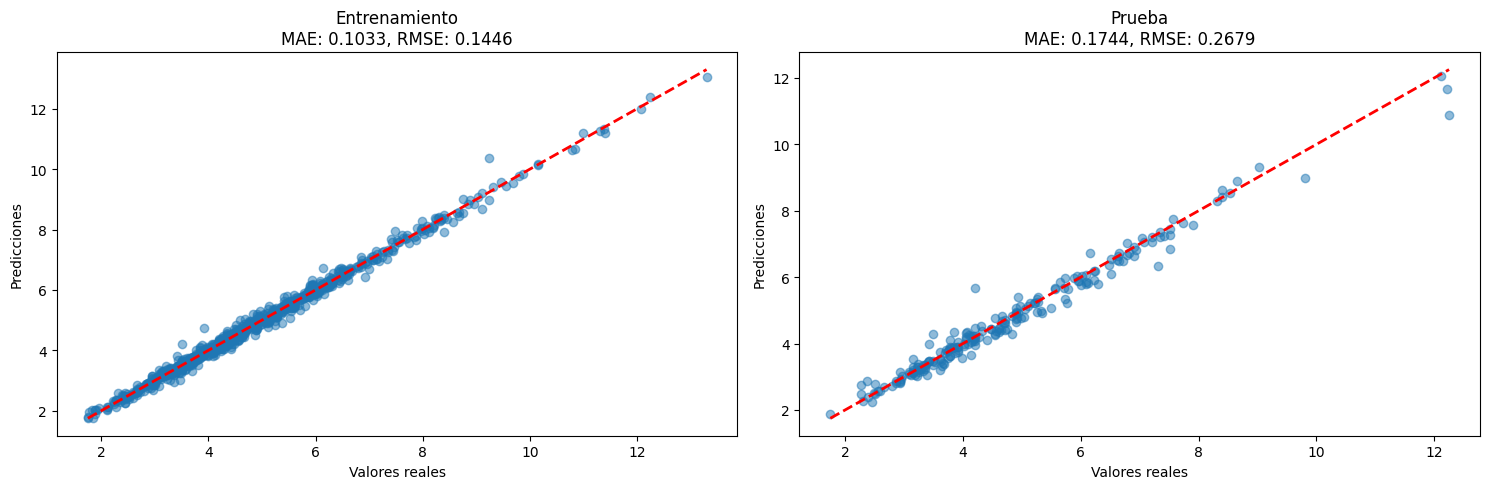

In [74]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title(f'Entrenamiento\nMAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}')

plt.subplot(122)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title(f'Prueba\nMAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}')

plt.tight_layout()
plt.show()